## Preprocessing and model build

**Import Libraries and load files**

In [1]:
#import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.pandas.set_option('display.max_rows',None)
pd.pandas.set_option('display.max_columns',None)

In [3]:
#load files
train = pd.read_csv('Train_complete.csv')
test = pd.read_csv('Test_complete.csv')

In [4]:
train.head(3)

# train.to_csv('test.csv',index=False)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,DisbursalAmount,EMI,ManufacturerID,LTV,SEX,AGE,MonthlyIncome,State,Top-up Month,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,DISBURSED-AMT/HIGH CREDIT,CURRENT-BAL,OVERDUE-AMT,WRITE-OFF-AMT
0,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,0,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,37352,37873,37873,0.0
1,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,0,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,44000,20797,0,0.0
2,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,1,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,145000,116087,0,0.0


<h2>New Feature developed : Number of loan acct for each ID

In [5]:
id_cnt_trn = train.groupby('ID')['ID'].count().to_dict()
train['ID_cnt'] = train['ID'].map(id_cnt_trn)


id_cnt_tst = test.groupby('ID')['ID'].count().to_dict()
test['ID_cnt'] = test['ID'].map(id_cnt_tst)

<h2>New Feature developed : Total current balance for each individual

In [6]:
dic_sum_current_bal = train.groupby('ID')['CURRENT-BAL'].sum().to_dict()
train['Total_current_bal'] = train['ID'].map(dic_sum_current_bal)

In [7]:
dic_sum_current_bal_test = test.groupby('ID')['CURRENT-BAL'].sum().to_dict()
test['Total_current_bal'] = test['ID'].map(dic_sum_current_bal_test)

In [8]:
train['Total_current_bal'] = np.where(train['Total_current_bal']==0,1,train['Total_current_bal'])
test['Total_current_bal'] = np.where(test['Total_current_bal']==0,1,test['Total_current_bal'])


<h2>New Feature developed : Liability of loan amount

In [9]:
train['Liability_loan'] = round(train['AssetCost'] + (train['MonthlyIncome']*12) / train['Total_current_bal'],2)
test['Liability_loan'] = round(test['AssetCost'] + (test['MonthlyIncome']*12) / test['Total_current_bal'],2)

<H2>Null Value treatment

In [10]:
#Find Nulls in BOTH DATE-REPORTED and DISBURSED-DT 
train[train['DATE-REPORTED'].isnull() & train['DISBURSED-DT'].isnull()].shape[0]

1228

In [11]:
#Drop the same rows
train.drop(train[train['DATE-REPORTED'].isnull() & train['DISBURSED-DT'].isnull()].index, inplace = True)

**Fill DATE-REPORTED with DISBURSED-DT and vice versa**

In [12]:
train['DATE-REPORTED'].fillna(train['DISBURSED-DT'], inplace = True)
test['DATE-REPORTED'].fillna(test['DISBURSED-DT'], inplace = True)

In [13]:
train['DISBURSED-DT'].fillna(train['DATE-REPORTED'], inplace = True)
test['DISBURSED-DT'].fillna(test['DATE-REPORTED'], inplace = True)

**Find Nulls in other fields and impute**

In [14]:
# pick up fields where there is null values
null_train = [var for var in train.columns if train[var].isnull().sum()>0]
null_train

['SEX', 'AGE', 'MonthlyIncome', 'WRITE-OFF-AMT', 'Liability_loan']

In [15]:
#fill up nulls with mode
for var in null_train:
    train[var].fillna(train[var].mode()[0], inplace=True)

In [16]:
#do the same for test set
null_test = [var for var in test.columns if test[var].isnull().sum()>0]
for var in null_test:
    test[var].fillna(test[var].mode()[0], inplace=True)

<h2>Distributions of continuous variables

In [17]:
num_ver = [var for var in train.columns if train[var].dtype != 'O' and var != 'ID']
num_ver

['BranchID',
 'Tenure',
 'AssetCost',
 'DisbursalAmount',
 'EMI',
 'ManufacturerID',
 'LTV',
 'AGE',
 'MonthlyIncome',
 'SELF-INDICATOR',
 'DISBURSED-AMT/HIGH CREDIT',
 'CURRENT-BAL',
 'OVERDUE-AMT',
 'WRITE-OFF-AMT',
 'ID_cnt',
 'Total_current_bal',
 'Liability_loan']

<h2> Key feature developped by summing LTV, EMI, MonthlyIncome, AssetCost

In [18]:
train['key-fet'] = train['LTV']*100000+train['EMI']+train[ 'MonthlyIncome']+train['AssetCost']
test['key-fet'] = test['LTV']*100000+test['EMI']+test[ 'MonthlyIncome']+test['AssetCost']

## Converted Date fields from text to datetime

In [19]:
#Converting to date DATE-REPORTED and DISBURSED-DT

train['DATE-REPORTED'] = pd.to_datetime(train['DATE-REPORTED'])
train['DISBURSED-DT'] = pd.to_datetime(train['DISBURSED-DT'])


test['DATE-REPORTED'] = pd.to_datetime(test['DATE-REPORTED'])
test['DISBURSED-DT'] = pd.to_datetime(test['DISBURSED-DT'])

## Difference between dates

In [20]:
#calculate the difference between DATE-REPORTED and DISBURSED-DT
train['date_diff'] = train['DATE-REPORTED'] - train['DISBURSED-DT']
train['date_diff'] = train['date_diff'] / np.timedelta64(1,'M')

In [21]:
#calculate the difference between DATE-REPORTED and DISBURSED-DT for test set
test['date_diff'] = test['DATE-REPORTED'] - test['DISBURSED-DT']
test['date_diff'] = test['date_diff'] / np.timedelta64(1,'M')

## Squize the data :
Select one row from each ID where disbursed-dt is max

In [22]:
train = train.loc[train.groupby('ID')['DISBURSED-DT'].idxmax()]
test = test.loc[test.groupby('ID')['DISBURSED-DT'].idxmax()]

In [23]:
#drop the date fields

train.drop(['DATE-REPORTED','DISBURSED-DT'],axis=1,inplace=True)

test.drop(['DATE-REPORTED','DISBURSED-DT'],axis=1,inplace=True)

## Create dummy of categorical variables

In [24]:
#selectng catagorical features

cat_var = [var for var in train.columns if train[var].dtype == 'O']

In [25]:
# Analyze Categorical Field


#Checking the distinct value present in each Categorial feature

def unique_count(df, var):
    df = df.copy()
    print(var, ' : ' ,df[var].nunique())
    
for var in cat_var:
    unique_count(train, var)

Frequency  :  4
InstlmentMode  :  2
LoanStatus  :  2
PaymentMode  :  11
SEX  :  2
State  :  22
Top-up Month  :  7
ACCT-TYPE  :  44
CONTRIBUTOR-TYPE  :  11
OWNERSHIP-IND  :  5
ACCOUNT-STATUS  :  9


**Group rare categorical fields in a same name**

In [26]:
def find_frequent_labels(df, var, rare_perc):
   
    # function finds the labels that are shared by more than
    # a certain % of the passengers in the dataset
   
    df = df.copy()
   
    tmp = df.groupby(var)[var].count() / len(df)
   
    return tmp[tmp > rare_perc].index


for var in cat_var:
   
    # find the frequent categories
    frequent_ls = find_frequent_labels(train, var, 0.01)
   
    # replace rare categories by the string "Rare"
    if var != 'Top-up Month':
       
        train[var] = np.where(train[var].isin(
            frequent_ls), train[var], 'Rare')

        test[var] = np.where(test[var].isin(
            frequent_ls), test[var], 'Rare')

In [27]:
#Creating dummies for categorical data


for var in cat_var:
     if var != 'Top-up Month':
        train = pd.get_dummies(train,columns=[var])
        test = pd.get_dummies(test,columns=[var])
   

In [28]:
col_train = train.columns
col_test = test.columns

for col in col_train:
    if col not in col_test:
        print(col)

Top-up Month
Frequency_Rare


In [29]:
#for final dataset we dont take ID and target variable

final_var = [var for var in train.columns if var not in ('Top-up Month','ID','Frequency_Rare','due_amt')]

**Convert the target into a numeric label, we create a dictionary for that**

In [30]:

target_dict = {'No Top-up Service':0, '12-18 Months':1, '18-24 Months':2 , '24-30 Months':3, 
               '30-36 Months':4, '36-48 Months':5, ' > 48 Months':6}

In [31]:
#saving ID which will be used to create submission dataframe

save_id = test['ID']

In [32]:
#Getting final dataset

X = train[final_var]
y = train['Top-up Month'].map(target_dict)

### Train Test Split

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Scalling

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[final_var] = scaler.fit_transform(X_train[final_var])
X_test[final_var] = scaler.transform(X_test[final_var])



In [35]:
test[final_var] = scaler.transform(test[final_var])

In [36]:
# create the training df by remerging X_train and y_train
df_train = X_train.join(y_train)


In [37]:
df_train['Top-up Month'].value_counts()

0    74704
6     5871
5     2521
3     2459
4     2146
2     1619
1      732
Name: Top-up Month, dtype: int64

**As this is an imbalanced dataset, we'll use undersampling**

In [38]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_train[df_train['Top-up Month']==0]
df_minority = df_train[df_train['Top-up Month']==6]
df_rest =  df_train[df_train['Top-up Month']!=6] [df_train['Top-up Month']!=0]

In [39]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples= 53449,     # to match minority class
                                 random_state=587) # reproducible results
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority,df_rest])
# Display new class counts
df_downsampled['Top-up Month'].value_counts()

0    53449
6     5871
5     2521
3     2459
4     2146
2     1619
1      732
Name: Top-up Month, dtype: int64

In [40]:
y_downsampled = df_downsampled['Top-up Month']
X_downsampled = df_downsampled.drop(['Top-up Month'], axis = 1)

## Machine Learning

In [54]:
#import libraries for Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score,classification_report

<h4> RandomForest Classifier - 1st Model

In [42]:
#fit the model with above found hyperparamets

# model_rf = RandomForestClassifier(random_state=42)

# model_rf.fit(X_downsampled,y_downsampled)

In [43]:
# pred_rf=model_rf.predict(X_test)
# print('f1_score',f1_score(y_test,pred_rf,average='macro'))

In [44]:
#Printing the 15 most important features for XGBModel

# imp_feat=pd.Series(model_rf.feature_importances_,index=final_var)
# plt.figure(figsize=(5,5))
# imp_feat.sort_values(ascending = False)[:15].plot(kind='barh')
# plt.show()

F1 score is poor for this

<h4> XGBClassifier - 2nd Model

In [55]:
# #XGBClassifier

from xgboost import XGBClassifier

model_xgb=XGBClassifier()
model_xgb.fit(X_downsampled,y_downsampled)
pred_xgb=model_xgb.predict(X_test)
print('f1_score',f1_score(y_test,pred_xgb,average='macro'))
print('Classification report\n', classification_report(y_test,pred_xgb))


f1_score 0.36334566082127223
Classification report
               precision    recall  f1-score   support

           0       0.89      0.98      0.93     31967
           1       0.37      0.13      0.19       302
           2       0.42      0.22      0.29       748
           3       0.41      0.21      0.28      1031
           4       0.44      0.13      0.21       916
           5       0.37      0.07      0.12      1135
           6       0.61      0.46      0.52      2495

    accuracy                           0.86     38594
   macro avg       0.50      0.32      0.36     38594
weighted avg       0.82      0.86      0.83     38594



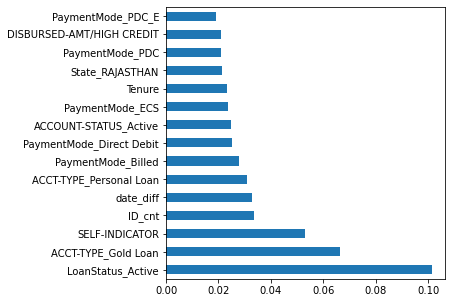

In [46]:
#Printing the 15 most important features for XGBModel

imp_feat=pd.Series(model_xgb.feature_importances_,index=final_var)
plt.figure(figsize=(5,5))
imp_feat.sort_values(ascending = False)[:15].plot(kind='barh')
plt.show()

**For better prediction we choose this model**

---

## Final submission

In [47]:
#prediction of test
# pred_final=model_rf.predict(test[final_var])
pred_final=model_xgb.predict(test[final_var])


In [48]:
#add ID and prediction in a Dataframe

final_df = pd.DataFrame({'ID':save_id, 'Top-up Month':pred_final})
final_df.head(5)

,ID,Top-up Month
0,4,0
7,5,6
18,6,0
25,25,0
26,119,0


In [49]:
#converting to label
convert_dic = {0:'No Top-up Service', 1:'12-18 Months', 2:'18-24 Months' , 3:'24-30 Months', 
               4:'30-36 Months', 5:'36-48 Months', 6:' > 48 Months'}
final_df['Top-up Month'] = final_df['Top-up Month'].map(convert_dic)
final_df.head(10)

,ID,Top-up Month
0,4,No Top-up Service
7,5,> 48 Months
18,6,No Top-up Service
25,25,No Top-up Service
26,119,No Top-up Service
34,126,No Top-up Service
51,127,> 48 Months
55,345,No Top-up Service
57,361,No Top-up Service
59,393,No Top-up Service


In [50]:
test.shape[0]

14745

In [51]:
final_df.shape[0]

14745

In [52]:
#convert to submission csv
final_df.to_csv('submission007.csv',index=False)